In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

# set default plot size to 20x10
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
# read data from csv
data_files = [
    {
        "name": "indoor_datset",
        "path": "./Sensor_Temp_23-04.csv",
        "sep": "|",
        "datatypes": ["datetime64[ns]", np.float64],
        "columns": ["timestamp", "temperature"]
    },
    {
        "name": "outdoor_dataset",
        "path": "./Temp_24.csv",
        "sep": ",",
        "datatypes": ["datetime64[ns]", np.float64],
        "columns": ["timestamp", "temperature"]
    },
]

In [4]:
dataset_names = [data_file["name"] for data_file in data_files]
datasets = [pd.read_csv(data_file["path"],
                        sep=data_file["sep"],
                        ) for data_file in data_files]

# apply column names
for dataset in datasets:
    dataset.columns = data_files[0]["columns"]


def parse_columns(dataset: pd.DataFrame, datatypes: list) -> pd.DataFrame:
    for i, col in enumerate(dataset.columns):
        dataset[col] = dataset[col].astype(datatypes[i])
    return dataset


# apply datatypes
datasets = [parse_columns(dataset, data_files[0]["datatypes"]) for dataset in datasets]
for dataset in datasets:
    print(len(dataset))

5712
60


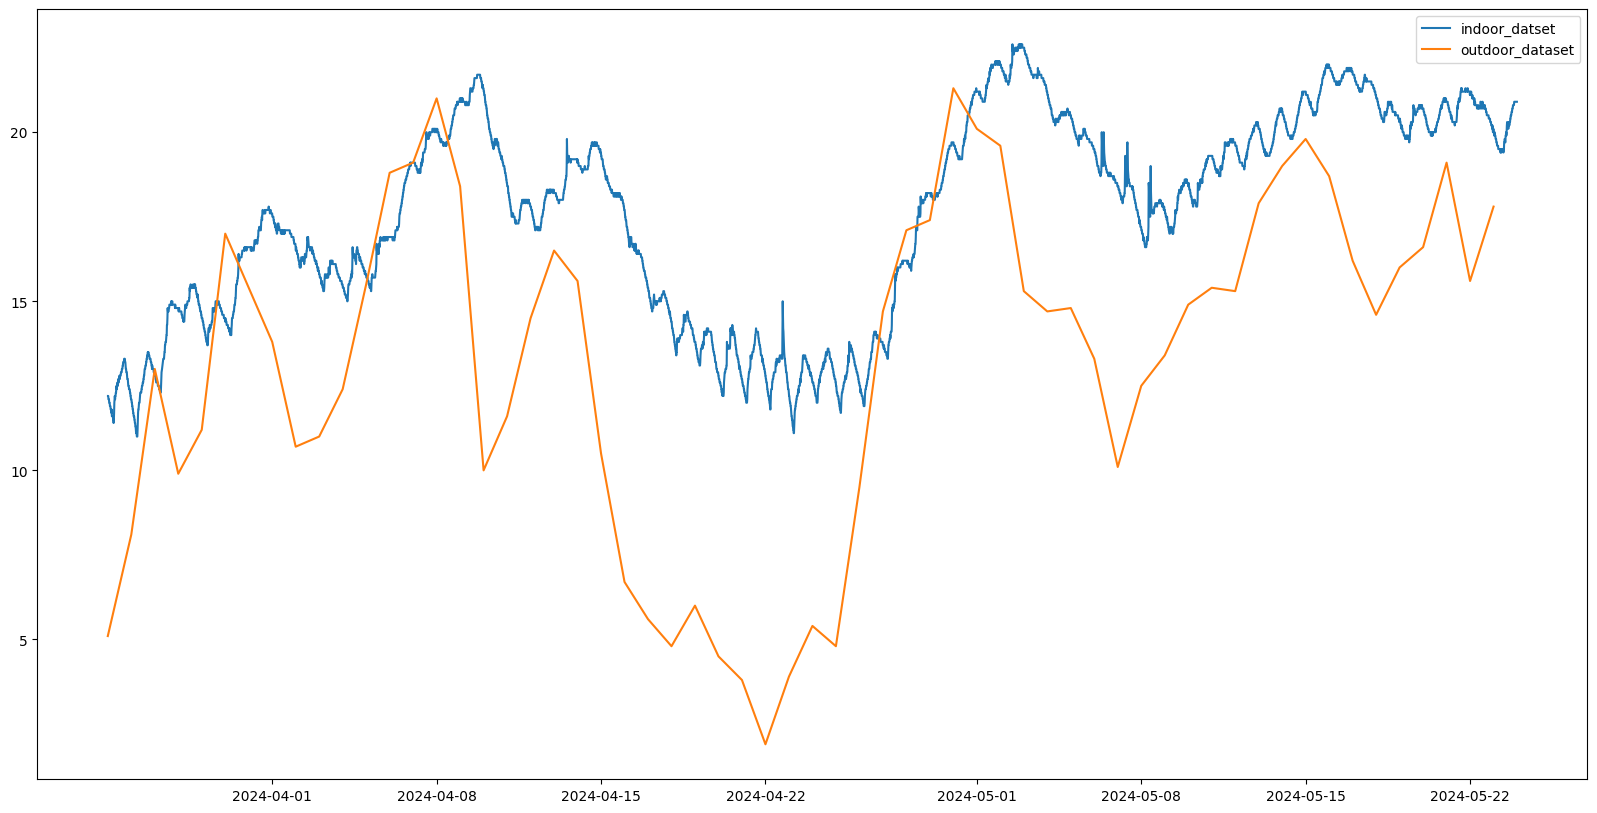

In [5]:
# plot the datasets
for i in range(len(datasets)):
    dataset = datasets[i]
    dataset_name = dataset_names[i]
    plt.plot(dataset.iloc[:, 0], dataset.iloc[:, 1], label=dataset_name)
    
plt.legend()
plt.show()

In [6]:
indoor_dataset = datasets[0]
outdoor_dataset = datasets[1]

In [7]:
# get sampling rate in measurements per day
sampling_rate_indoor = int(np.timedelta64(1, "D") / indoor_dataset["timestamp"].diff().mean())
sampling_rate_outdoor = int(np.timedelta64(1, "D") / outdoor_dataset["timestamp"].diff().mean())
f"Indoor: {sampling_rate_indoor} measurements per day, Outdoor: {sampling_rate_outdoor} measurements per day"

'Indoor: 95 measurements per day, Outdoor: 1 measurements per day'

In [8]:
# resample to daily average
indoor_dataset = indoor_dataset.resample("D", on="timestamp").mean()
outdoor_dataset = outdoor_dataset.resample("D", on="timestamp").mean()

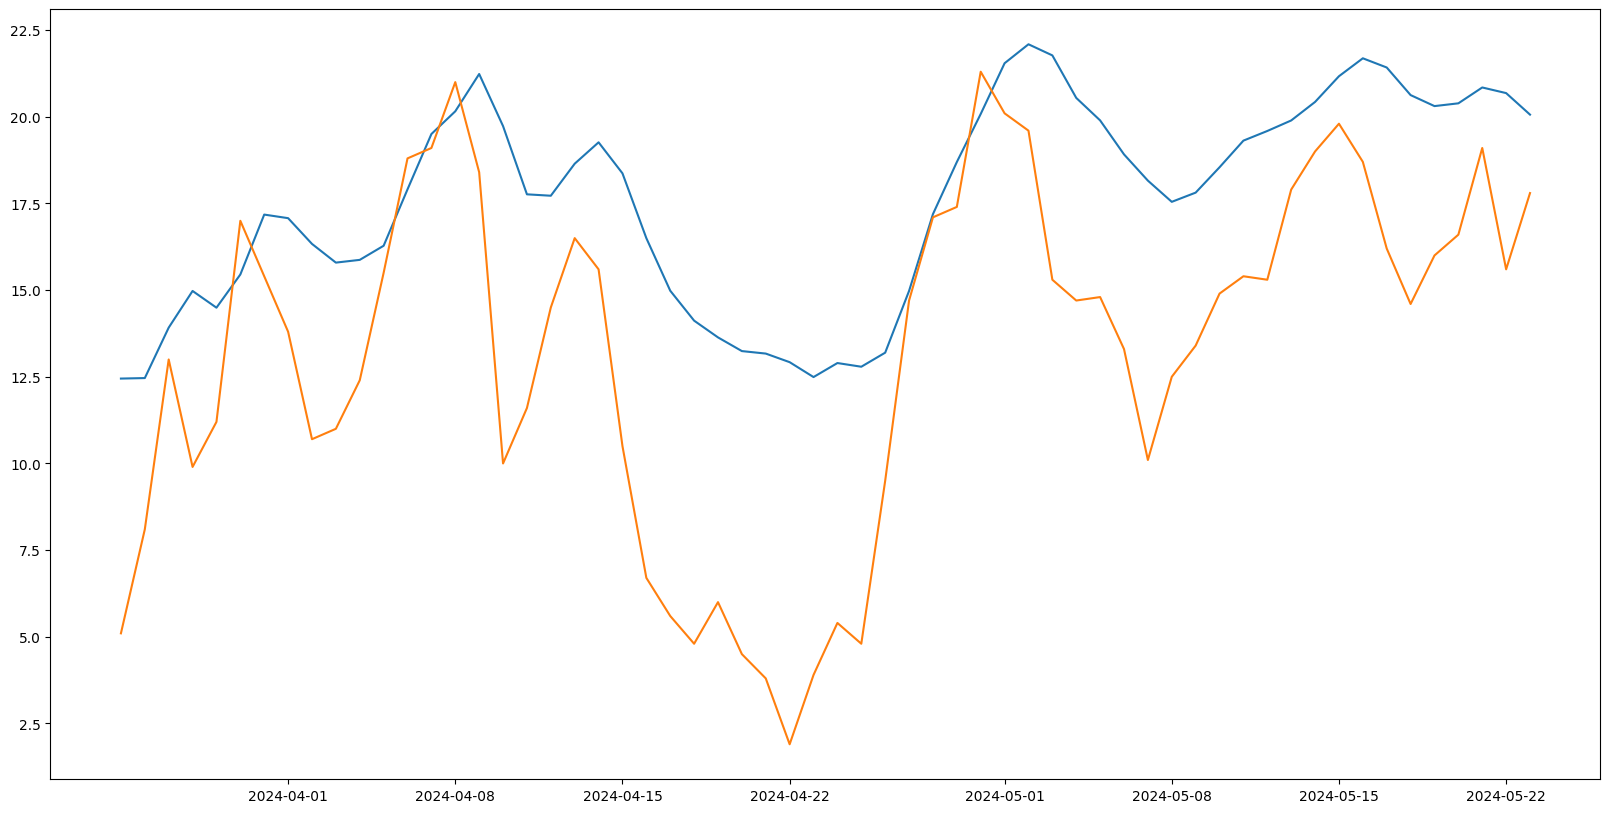

In [9]:
# plot resampled datasets
plt.plot(indoor_dataset.index, indoor_dataset["temperature"])
plt.plot(outdoor_dataset.index, outdoor_dataset["temperature"])
plt.show()

In [ ]:
# Indoor dataset seems to have lag of one day, might be misaligned, or actually have a lag.
# might be interesting to dig deeper into this

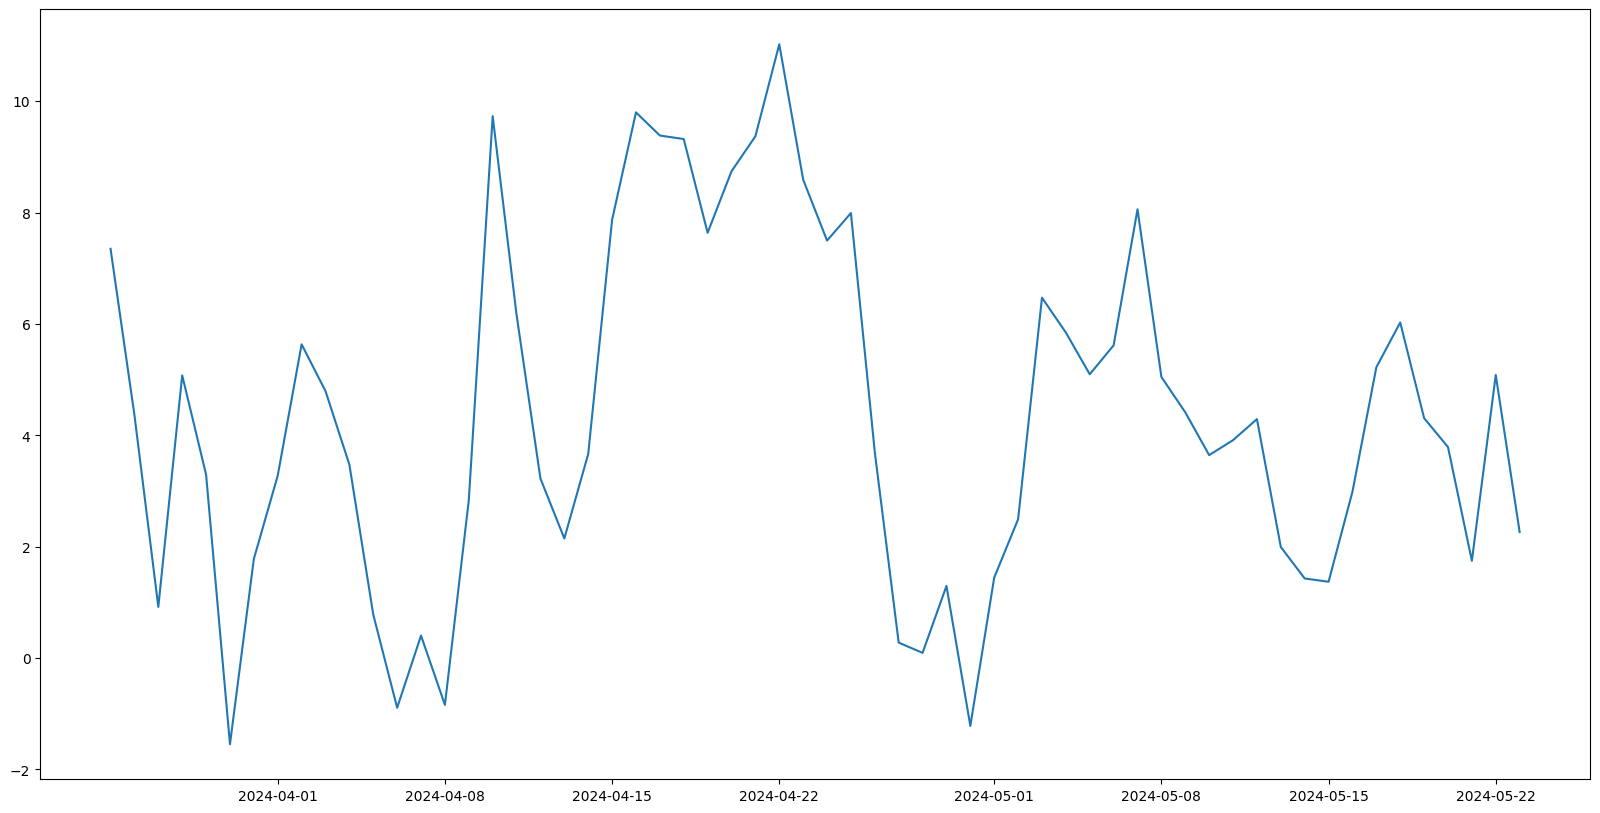

In [10]:
# plot diff
plt.plot(indoor_dataset.index, indoor_dataset["temperature"] - outdoor_dataset["temperature"])

In [11]:
# the idea is to predict the indoor temperature based on the outdoor temperature
# X is our input, so the outdoor temperature, y is the indoor temperature
# X needs to be reshaped to 2D array, since most models take the input in the shape (len(dataset), num_features)
# we only have one feature here, so we need to reshape it to (len(dataset), 1), that's what the -1 does
# we also need to split the dataset into train and test sets, here we use 80% for training and 20% for testing

In [22]:
# create train/test splits
from sklearn.model_selection import train_test_split


# reshape to 2D array, required for model training (len(dataset), num_features)
X = outdoor_dataset["temperature"].values.reshape(-1, 1)
y = indoor_dataset["temperature"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

f"Train: {len(X_train)}, Test: {len(X_test)}"

'Train: 48, Test: 12'

In [23]:
# now we can train different models and compare their performances
# we will use linear regression, support vector regression, random forest regression and mlp regression
# we will use mean squared error as our performance metric
# we will also plot the prediction for the whole dataset to see how well the model generalizes
# it should be noted, that the models are trained on a very small dataset, so the generalization might not be very good

In [24]:
# train linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred)

2.7568637534131746

MSE on whole dataset: 2.756839777634529


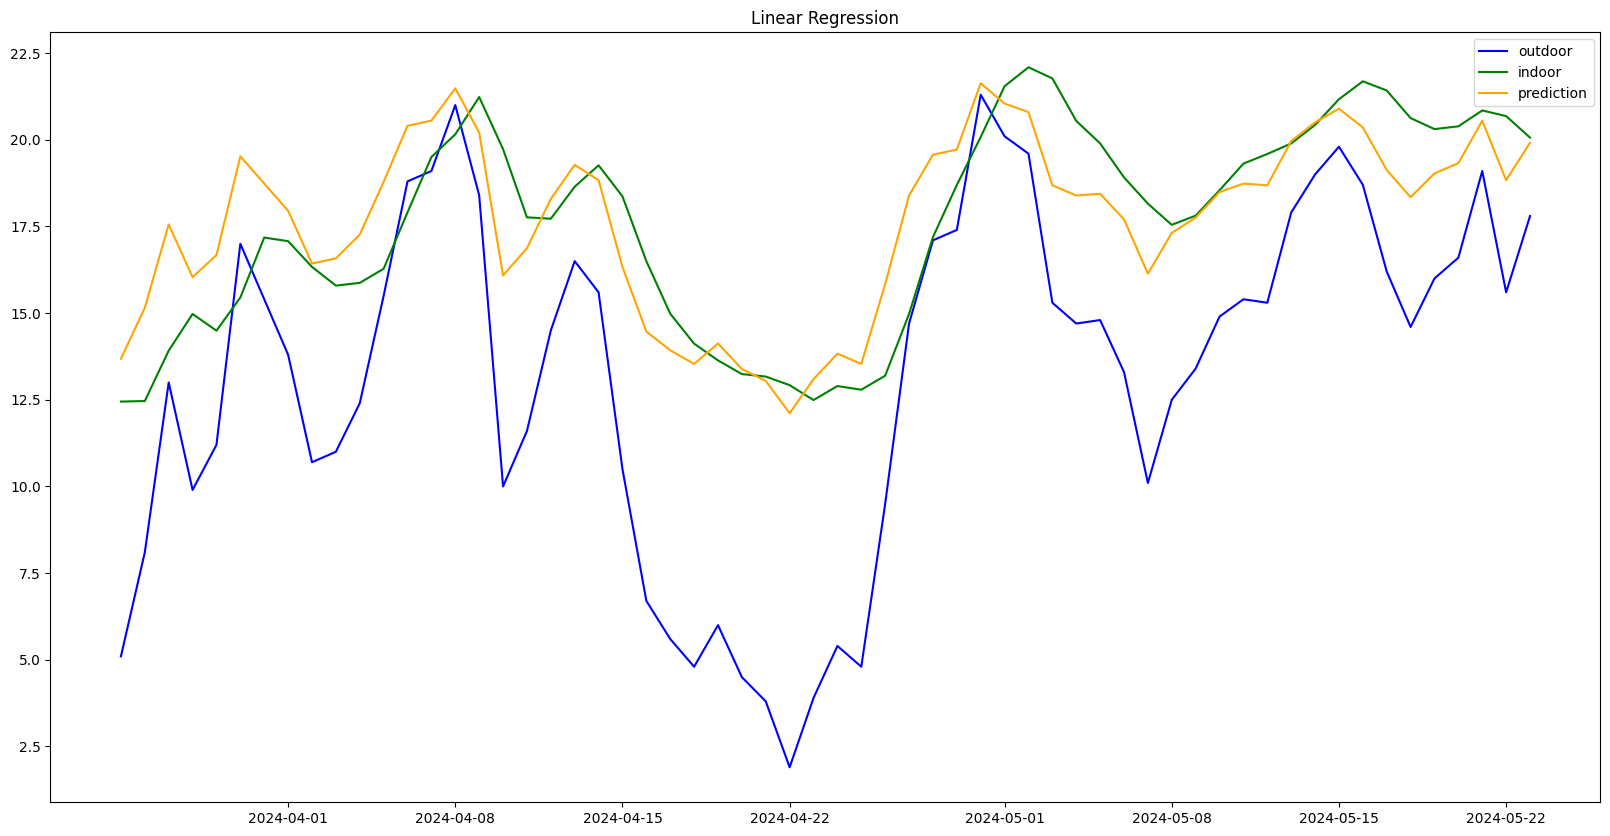

In [25]:
# plot prediction for whole dataset
y_pred = lr.predict(X)
print(f"MSE on whole dataset: {mean_squared_error(y, y_pred)}")
plt.title("Linear Regression")
plt.plot(outdoor_dataset.index, outdoor_dataset["temperature"], color="blue", label="outdoor")
plt.plot(indoor_dataset.index, indoor_dataset["temperature"], color="green", label="indoor")
plt.plot(indoor_dataset.index, y_pred, color="orange", label="prediction")
plt.legend()
plt.show()

In [26]:
# train support vector regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mean_squared_error(y_test, y_pred)

3.0718352406194263

2.890388122554327


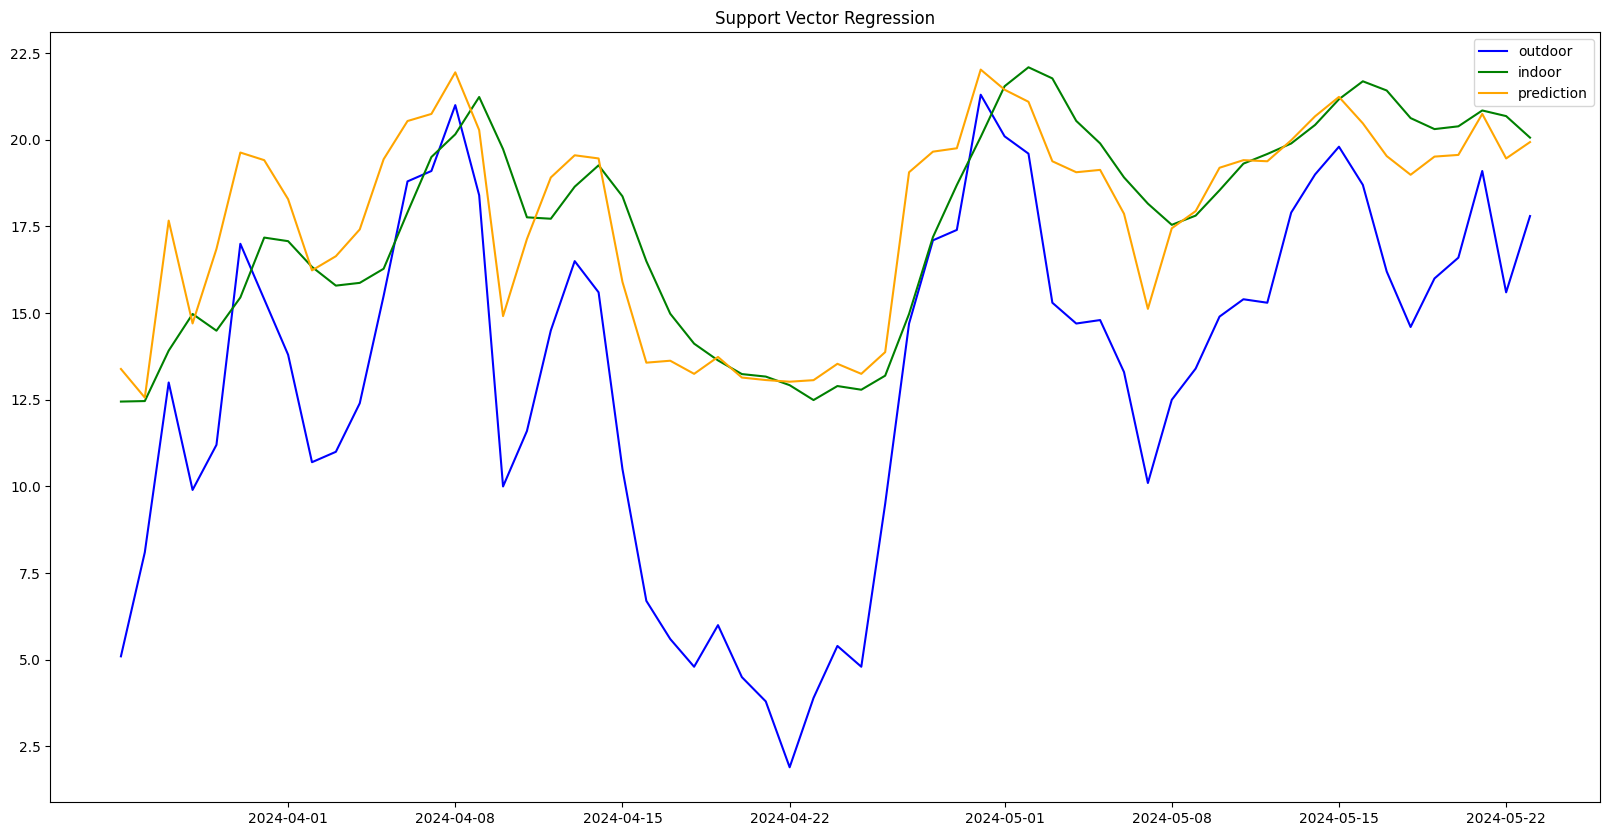

In [27]:
# plot prediction for whole dataset
y_pred = svr.predict(X)
print(mean_squared_error(y, y_pred))
plt.title("Support Vector Regression")
plt.plot(outdoor_dataset.index, outdoor_dataset["temperature"], color="blue", label="outdoor")
plt.plot(indoor_dataset.index, indoor_dataset["temperature"], color="green", label="indoor")
plt.plot(indoor_dataset.index, y_pred, color="orange", label="prediction")
plt.legend()
plt.show()

In [28]:

# train random forest regression to predict indoor temperature
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred)

4.75178813225732

MSE on whole dataset: 1.614834284076756


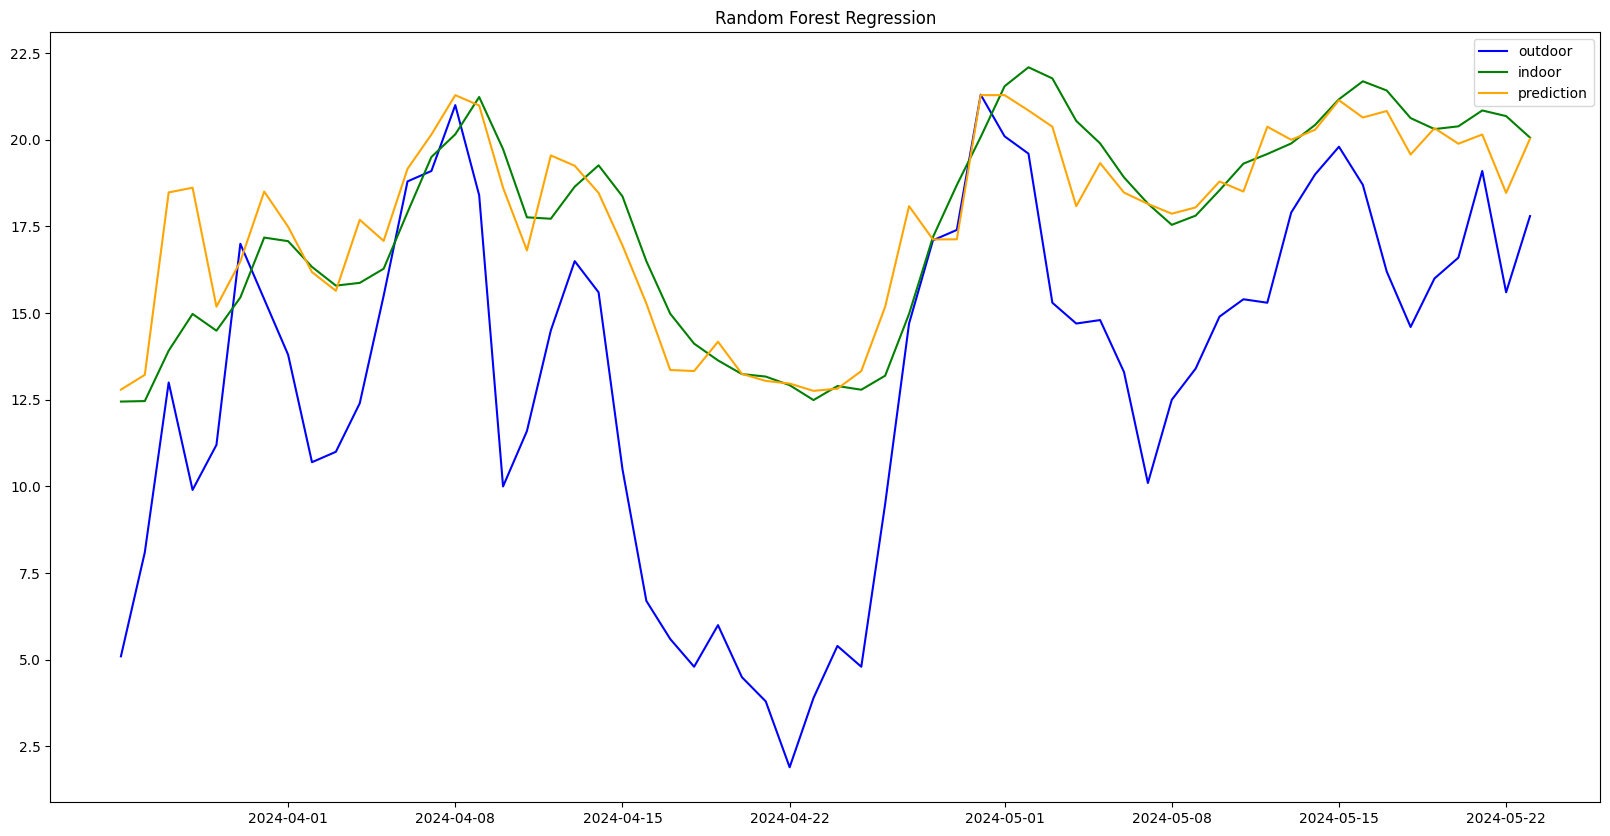

In [29]:
# plot prediction for whole dataset
y_pred = rf.predict(X)
print(f"MSE on whole dataset: {mean_squared_error(y, y_pred)}")
plt.title("Random Forest Regression")
plt.plot(outdoor_dataset.index, outdoor_dataset["temperature"], color="blue", label="outdoor")
plt.plot(indoor_dataset.index, indoor_dataset["temperature"], color="green", label="indoor")
plt.plot(indoor_dataset.index, y_pred, color="orange", label="prediction")
plt.legend()
plt.show()

In [30]:
# since the dataset is very small, the models performance is highly dependent on the random initialization of the weights
# so we will train the model multiple times with different random states and use the best model

In [31]:
# train mlp regression to predict indoor temperature
from sklearn.neural_network import MLPRegressor
import warnings

# ignore warnings during mlp training
warnings.filterwarnings("ignore")

# train with n different random states, use best model
best_model = None
best_error = 1e10 # set to high value
n_iterations = 10 # increase for better results
for i in tqdm(range(n_iterations)):
    # get randint for random state
    random_state = np.random.randint(0, 1_000)
    mlp = MLPRegressor(hidden_layer_sizes=(2, 1), max_iter=10_000, random_state=random_state)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    # replace best model if error is lower
    if error < best_error:
        best_error = error
        best_model = mlp
    print(f"Current best model error: {best_error}")

# enable warnings again
warnings.filterwarnings("default")

f"Best error: {best_error} @ random state: {best_model.random_state}"

 10%|█         | 1/10 [00:01<00:13,  1.45s/it]

Current best model error: 2.83518100979432


 20%|██        | 2/10 [00:03<00:15,  1.92s/it]

Current best model error: 2.7920259258218985


 30%|███       | 3/10 [00:05<00:12,  1.78s/it]

Current best model error: 2.7920259258218985


 40%|████      | 4/10 [00:07<00:10,  1.80s/it]

Current best model error: 2.7920259258218985


 50%|█████     | 5/10 [00:09<00:10,  2.11s/it]

Current best model error: 2.7920259258218985


 60%|██████    | 6/10 [00:13<00:10,  2.59s/it]

Current best model error: 2.7920259258218985


 70%|███████   | 7/10 [00:14<00:06,  2.25s/it]

Current best model error: 2.7920259258218985


 80%|████████  | 8/10 [00:18<00:05,  2.58s/it]

Current best model error: 2.7920259258218985


 90%|█████████ | 9/10 [00:21<00:02,  2.74s/it]

Current best model error: 2.7920259258218985


100%|██████████| 10/10 [00:24<00:00,  2.50s/it]

Current best model error: 2.7920259258218985


'Best error: 2.7920259258218985 @ random state: 352'

MSE on whole dataset: 2.7844625058953087


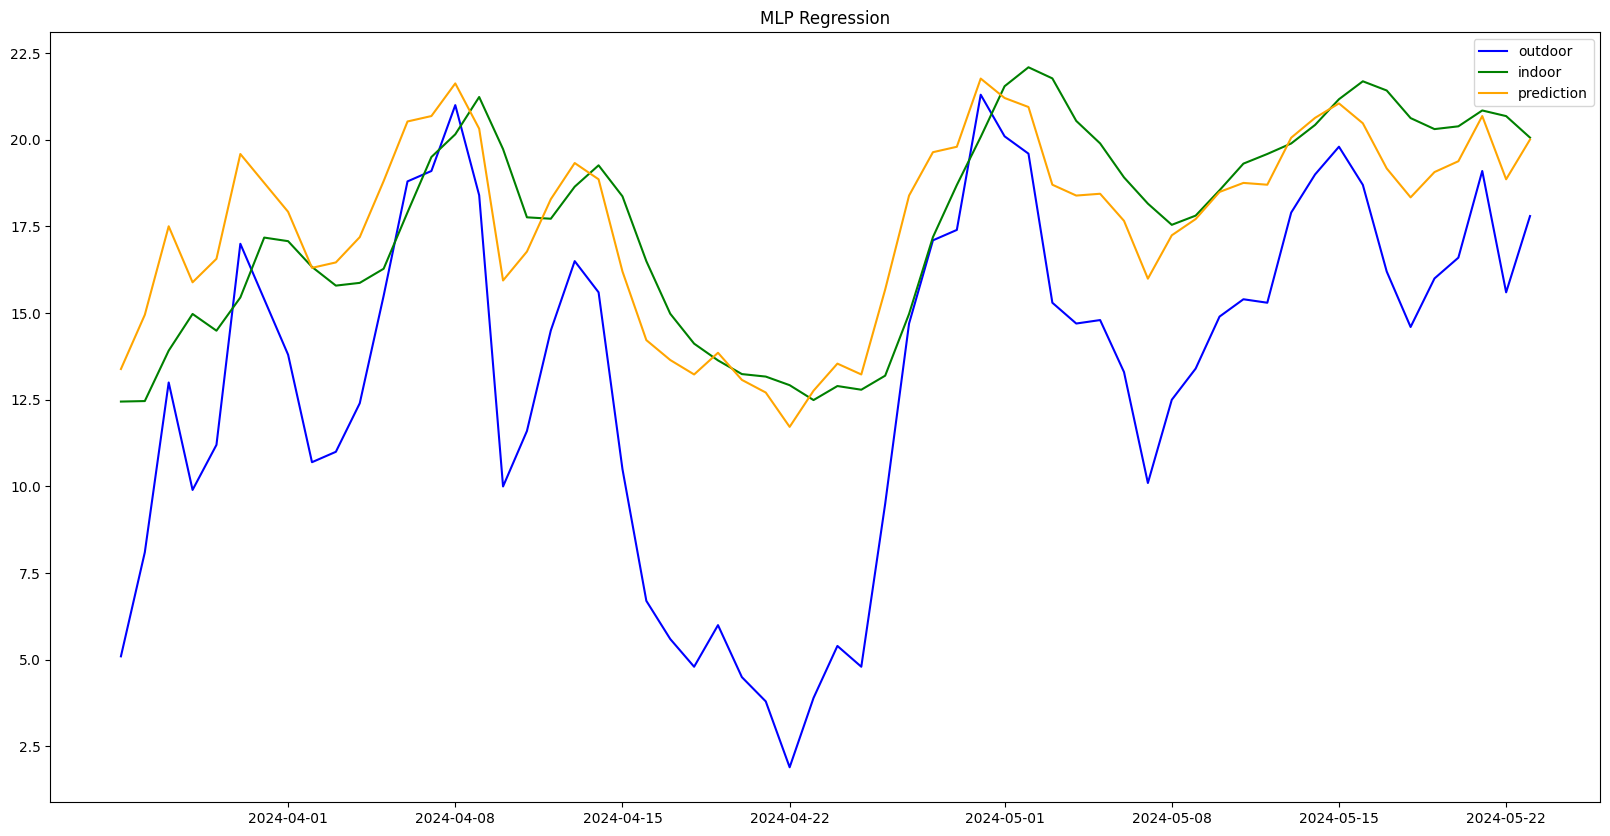

In [32]:
# plot prediction for whole dataset
y_pred = best_model.predict(X)
print(f"MSE on whole dataset: {mean_squared_error(y, y_pred)}")
plt.title("MLP Regression")
plt.plot(outdoor_dataset.index, outdoor_dataset["temperature"], color="blue", label="outdoor")
plt.plot(indoor_dataset.index, indoor_dataset["temperature"], color="green", label="indoor")
plt.plot(indoor_dataset.index, y_pred, color="orange", label="prediction")
plt.legend()
plt.show()